# Objective
- base model without oversampling and feature selection & fine tune it
- base model with oversampling and feature selection & fine tune it

In [ ]:
import warnings
from collections import Counter
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

warnings.filterwarnings("ignore")

In [ ]:
# Load the preprocessed dataset (299 records; with 14 features).
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

### Parameters for SVM

In [ ]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid search.
parameters = dict()
parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
# Tried even with 30 - takes longer but still chooses 1.
parameters['C'] = arange(1, 10, 1)
parameters['gamma'] = ['scale', 'auto']
parameters['class_weight'] = ['dict', 'balanced']

# A stratified K fold for cross validation strategy - values are assigned from the global class.
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Reset accuracies for SVM
ev.accuracies = {}

### Base Model (Function)

In [ ]:
reload(ev)
# A function to build base model.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_base_model(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    svc= SVC(verbose=verbose)
    svc.fit(x_train, y_train)

    # Do prediction with the train model.
    y_pred = svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, svc, test_name)

### Grid Search CV (Function)

In [ ]:
reload(ev)
# A function to build and fine tune model using GridSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    grid_svc= SVC(verbose=verbose)

    ## Building Grid Search algorithm with cross-validation and acc score.
    grid_search_svc = GridSearchCV(grid_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    grid_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params          :{grid_search_svc.best_params_}.')
    print(f'Best score (*mean)   :{grid_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = grid_search_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, grid_search_svc, test_name)

### Random Search CV (Function)

In [ ]:
reload(ev)
# A function to build and fine tune model using RandomSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_with_random_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    rand_svc= SVC(verbose=verbose)

    ## Building Random Search algorithm with cross-validation and acc score.
    rand_search_svc = RandomizedSearchCV(rand_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    rand_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{rand_search_svc.best_params_}.')
    print(f'Best score  :{rand_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = rand_search_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_search_svc, test_name)

## Evaluation with Standard Dataset (without over-sampling)

### Data Preparation

In [ ]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

In [ ]:
# Evaluation: Standard Base
build_and_validate_base_model(X, y,ev.EvaluationType.std_base)

In [ ]:
# Evaluation: Standard Grid Search CV
build_and_validate_with_grid_search_cv(X, y, ev.EvaluationType.std_grid_search_cv)

In [ ]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X, y, ev.EvaluationType.std_random_search_cv)

In [ ]:
print(ev.accuracies)

## Evaluation with Over-sampled Dataset

### Data Preparation and Over-sampling

In [ ]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE().fit_resample(X, y)
print(f'Classes before over-sampling :{Counter(data[uci.UCIHeartDiseaseData.target])}.')
print(f'Classes after over-sampling  :{Counter(y_b)}.')

In [ ]:
# Before over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=data[uci.UCIHeartDiseaseData.target])

# After over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=y_b)

In [ ]:
# Evaluation: Over-sampled Base
build_and_validate_base_model(X_b, y_b,ev.EvaluationType.os_base)

In [ ]:
# Evaluation: Over-sampled Grid Search CV
build_and_validate_with_grid_search_cv(X_b, y_b, ev.EvaluationType.os_grid_search_cv)

In [ ]:
# Evaluation: Over-sampled Random Search CV
build_and_validate_with_random_search_cv(X_b, y_b, ev.EvaluationType.os_random_search_cv)

In [200]:
print(ev.accuracies)

{'std-base': 85, 'std-grid-scv': 87, 'std-rand-scv': 87, 'os-base': 80, 'os-grid-scv': 75, 'os-rand-scv': 82}


## Conclusion

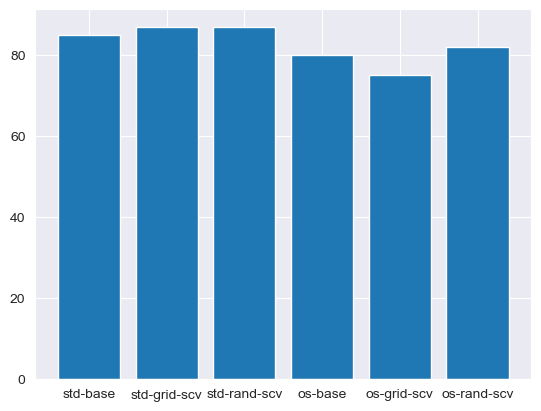

In [202]:
plt.bar(range(len(ev.accuracies)), list(ev.accuracies.values()), align='center')
plt.xticks(range(len(ev.accuracies)), list(ev.accuracies.keys()))

plt.show()

In [203]:
### Register the highest in global
ev.global_accuracies['SVM'] = 87